#EECS 504 PS4: Backpropagation

Please provide the following information 
(e.g. Andrew Owens, ahowens):

Rucha Apte, ruchaa




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.datasets import CIFAR10
download = not os.path.isdir('cifar-10-batches-py')
dset_train = CIFAR10(root='.', download=download)


# Problem 4.2 Multi-layer perceptron
In this problem you will develop a two Layer neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

We train the network with a softmax loss function on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer. In other words, the network has the following architecture:

input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class.

You cannot use any deep learning libraries such as PyTorch in this part.

# 4.2 (a) Layers
In this problem, implement fully connected layer, relu and softmax. Filling in all TODOs in skeleton codes will be sufficient.

In [0]:
def fc_forward(x, w, b):
    """
    Computes the forward pass for a fully-connected layer.
    
    The input x has shape (N, Din) and contains a minibatch of N
    examples, where each example x[i] has shape (Din,).
    
    Inputs:
    - x: A numpy array containing input data, of shape (N, Din)
    - w: A numpy array of weights, of shape (Din, Dout)
    - b: A numpy array of biases, of shape (Dout,)
    
    Returns a tuple of:
    - out: output, of shape (N, Dout)
    - cache: (x, w, b)
    """
    ###########################################################################
    # TODO: Implement the forward pass. Store the result in out.              #
    ###########################################################################
    N = x.shape[0]
    #M = x.shape[1:]
    M = np.prod(x.shape[1:])
    x_new = np.reshape(x,(N,M))
    out = np.dot(x_new,w) + b
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def fc_backward(dout, cache):
    """
    Computes the backward pass for a fully_connected layer.
    
    Inputs:
    - dout: Upstream derivative, of shape (N, Dout)
    - cache: returned by your forward function. Tuple of:
      - x: Input data, of shape (N, Din)
      - w: Weights, of shape (Din, Dout)
      - b: Biases, of shape (Dout,)
      
    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, Din)
    - dw: Gradient with respect to w, of shape (Din, Dout)
    - db: Gradient with respect to b, of shape (Dout,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    N = x.shape[0] 
    #M = x.shape[1:]
    M=np.prod(x.shape[1:])
    x_new = np.reshape(x,(N,M))

    dx_mid = np.dot(dout,np.transpose(w))

    dx = np.reshape(dx_mid, x.shape)   
    dw = np.dot(np.transpose(x_new), dout)      
    db = np.dot(np.transpose(dout), np.ones(N))

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = x
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    out = np.maximum(x,0)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: returned by your forward function. Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = dout, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    #m,n=dout.shape
    #for k in range (m):
      #if dx[k] <= 0:
        #dx[k] = 0
    #dx[x > 0] = 1    
    dx[x <= 0] = 0
    #dx= 1. * (x > 0) 
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    ###########################################################################
    # TODO: Implement softmax loss                                            #
    ###########################################################################
    softmax = np.exp(x - np.max(x, axis=1, keepdims=True))
    #softmax = np.exp(x - np.max(x, axis=1))
    softmax = softmax/(np.sum(softmax, axis=1, keepdims=True))
    #softmax = softmax/(np.sum(softmax, axis=1))
    N,C = x.shape
    loss = -np.sum(np.log(softmax[np.arange(N), y])) / N
    
    softmax[np.arange(N), y] =softmax[np.arange(N), y] - 1
    dx = softmax / N
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx

# 4.2 (b) Softmax Classifier

In this problem, implement softmax classifier.

In [0]:
class SoftmaxClassifier(object):
    """
    A fully-connected neural network with
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecture should be fc - relu - fc - softmax with one hidden layer

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3072, hidden_dim=300, num_classes=10,
                 weight_scale=1e-3):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer, None
          if there's no hidden layer.
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        """
        self.params = {}
        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with fc weights and biases using the keys        #
        # 'W' and 'b', i.e., W1, b1 for the weights and bias in the first linear   #
        # layer, W2, b2 for the weights and bias in the second linear layer.       #
        ############################################################################
        #self.hidden_dim = 
        self.params['W1'] = np.random.randn(input_dim, hidden_dim) * weight_scale 
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = np.random.randn(hidden_dim, num_classes) * weight_scale
        self.params['b2'] = np.zeros(num_classes)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def forwards_backwards(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, Din)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass. And
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        forward_layer_output_1, forward_layer_cache_1 = fc_forward(X, self.params['W1'], self.params['b1'])
        relu_output, relu_cache = relu_forward(forward_layer_output_1)
        forward_layer_output_2, forward_layer_cache_2 = fc_forward(relu_output, self.params['W2'], self.params['b2'])
        scores = forward_layer_output_2
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k].                                                          # 
        ############################################################################
        loss, gradients = softmax_loss(scores, y)
        backward_layer_output_2, grads['W2'], grads['b2'] = fc_backward(gradients, forward_layer_cache_2)
        backward_layer_relu = relu_backward(backward_layer_output_2, relu_cache)
        backward_layer_ouput_1, grads['W1'], grads['b1'] = fc_backward(backward_layer_relu, forward_layer_cache_1)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return loss, grads

  


# 4.2(c) Training

In this problem, you need to preprocess the images and set up model hyperparameters. Notice that adjust the training and val split is optional.

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding="latin1")
    return dict

def load_cifar10():
    data = {}
    meta = unpickle("cifar-10-batches-py/batches.meta")
    batch1 = unpickle("cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("cifar-10-batches-py/data_batch_5")
    test_batch = unpickle("cifar-10-batches-py/test_batch")
    X_train = np.vstack((batch1['data'], batch2['data'], batch3['data'],\
                         batch4['data'], batch5['data']))
    Y_train = np.array(batch1['labels'] + batch2['labels'] + batch3['labels'] + 
                       batch4['labels'] + batch5['labels'])
    X_test = test_batch['data']
    Y_test = test_batch['labels']
    
    #Preprocess images here                                     
    X_train = (X_train-np.mean(X_train,axis=1,keepdims=True))/np.std(X_train,axis=1,keepdims=True)
    X_test = (X_test-np.mean(X_test,axis=1,keepdims=True))/np.std(X_test,axis=1,keepdims=True)

    data['X_train'] = X_train[:40000]
    data['y_train'] = Y_train[:40000]
    data['X_val'] = X_train[40000:]
    data['y_val'] = Y_train[40000:]
    data['X_test'] = X_test
    data['y_test'] = Y_test
    return data

def test_network(model, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.

    Inputs:
    - model: Image classifier
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using
      too much memory.

    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """

    # Subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N = num_samples
        X = X[mask]
        y = y[mask]

    # Compute predictions in batches
    num_batches = N // batch_size
    if N % batch_size != 0:
        num_batches += 1
    y_pred = []
    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        scores = model.forwards_backwards(X[start:end])
        y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc


def train_network(model, data, **kwargs):
    """
     Required arguments:
    - model: Image classifier
    - data: A dictionary of training and validation data containing:
      'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
      'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
      'y_train': Array, shape (N_train,) of labels for training images
      'y_val': Array, shape (N_val,) of labels for validation images

    Optional arguments:
    - learning_rate: A scalar for initial learning rate.
    - lr_decay: A scalar for learning rate decay; after each epoch the
      learning rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient
      during training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every
      print_every iterations.
    - verbose: Boolean; if set to false then no output will be printed
      during training.
    - num_train_samples: Number of training samples used to check training
      accuracy; default is 1000; set to None to use entire training set.
    - num_val_samples: Number of validation samples to use to check val
      accuracy; default is None, which uses the entire validation set.
    """
    
    
    learning_rate =  kwargs.pop('learning_rate', 1e-3)
    lr_decay = kwargs.pop('lr_decay', 1.0)
    batch_size = kwargs.pop('batch_size', 100)
    num_epochs = kwargs.pop('num_epochs', 10)
    num_train_samples = kwargs.pop('num_train_samples', 1000)
    num_val_samples = kwargs.pop('num_val_samples', None)
    print_every = kwargs.pop('print_every', 10)   
    verbose = kwargs.pop('verbose', True)
    
    epoch = 0
    best_val_acc = 0
    best_params = {}
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    
    num_train = data['X_train'].shape[0]
    iterations_per_epoch = max(num_train // batch_size, 1)
    num_iterations = num_epochs * iterations_per_epoch
    

    
    for t in range(num_iterations):
        # Make a minibatch of training data
        batch_mask = np.random.choice(num_train, batch_size)
        X_batch = data['X_train'][batch_mask]
        y_batch = data['y_train'][batch_mask]
        
        # Compute loss and gradient
        loss, grads = model.forwards_backwards(X_batch, y_batch)
        loss_history.append(loss)

        # Perform a parameter update
        for p, w in model.params.items():
            model.params[p] = w - grads[p]*learning_rate
          
        # Print training loss
        if verbose and t % print_every == 0:
            print('(Iteration %d / %d) loss: %f' % (
                   t + 1, num_iterations, loss_history[-1]))
         
        # At the end of every epoch, increment the epoch counter and decay
        # the learning rate.
        epoch_end = (t + 1) % iterations_per_epoch == 0
        if epoch_end:
            epoch += 1
            learning_rate *= lr_decay
        
        # Check train and val accuracy on the first iteration, the last
        # iteration, and at the end of each epoch.
        first_it = (t == 0)
        last_it = (t == num_iterations - 1)
        if first_it or last_it or epoch_end:
            train_acc = test_network(model, data['X_train'], data['y_train'],
                num_samples= num_train_samples)
            val_acc = test_network(model, data['X_val'], data['y_val'],
                num_samples=num_val_samples)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            if verbose:
                print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                       epoch, num_epochs, train_acc, val_acc))

            # Keep track of the best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {}
                for k, v in model.params.items():
                    best_params[k] = v.copy()
        
    model.params = best_params
        
    return model, train_acc_history, val_acc_history
        

# load data
data = load_cifar10() 
train_data = { k: data[k] for k in ['X_train', 'y_train', 
                                    'X_val', 'y_val']}
#######################################################################
# TODO: Set up model hyperparameters                                  #
#######################################################################

# initialize model
model = SoftmaxClassifier(hidden_dim =350, weight_scale=1e-2)

# start training    
model, train_acc_history, val_acc_history = train_network(
    model, train_data, learning_rate =1e-3 ,
    lr_decay=1.0, num_epochs=10, 
    batch_size=10, print_every=1000)
#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################


(Iteration 1 / 40000) loss: 2.333097
(Epoch 0 / 10) train acc: 0.104000; val_acc: 0.107400
(Iteration 1001 / 40000) loss: 2.190750
(Iteration 2001 / 40000) loss: 2.070655
(Iteration 3001 / 40000) loss: 1.900290
(Epoch 1 / 10) train acc: 0.396000; val_acc: 0.365200
(Iteration 4001 / 40000) loss: 2.324320
(Iteration 5001 / 40000) loss: 1.795993
(Iteration 6001 / 40000) loss: 1.531608
(Iteration 7001 / 40000) loss: 1.605323
(Epoch 2 / 10) train acc: 0.423000; val_acc: 0.412400
(Iteration 8001 / 40000) loss: 1.427910
(Iteration 9001 / 40000) loss: 1.654643
(Iteration 10001 / 40000) loss: 1.476426
(Iteration 11001 / 40000) loss: 1.477906
(Epoch 3 / 10) train acc: 0.460000; val_acc: 0.429600
(Iteration 12001 / 40000) loss: 1.492595
(Iteration 13001 / 40000) loss: 1.601732
(Iteration 14001 / 40000) loss: 1.370751
(Iteration 15001 / 40000) loss: 1.381645
(Epoch 4 / 10) train acc: 0.461000; val_acc: 0.448000
(Iteration 16001 / 40000) loss: 1.270154
(Iteration 17001 / 40000) loss: 1.024541
(Iter

# 4.2(c) Report Accuracy

Run the given code and report the accuracy on test set.


In [5]:
# report test accuracy
acc = test_network(model, data['X_test'], data['y_test'])
print("Test accuracy: {}".format(acc))

Test accuracy: 0.5003


# 4.2(d) Plot

Using the train_acc_history and val_acc_history, plot the train & val accuracy versus epochs on one plot. 

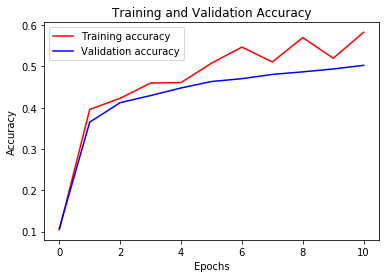

In [6]:
num_epochs=range(0,11)
plt.plot(num_epochs, train_acc_history, 'r', label='Training accuracy')
plt.plot(num_epochs, val_acc_history, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()